## **Monster × VISTA Cross-Match (per HTM7 shard)**

This notebook:
- Cross-matches Monster shards with VISTA-VIDEO-CDFS-DR5 catalog
- Keeps **all Monster rows** (unmatched get NaN in VIDEO fluxes)
- For a simplified first test, the matched output is restricted to just the VISTA aper-3 fluxes and their errors
- Saves the output shards into **LSST AFW `SimpleCatalog` FITS format**

We use:
- **Astropy** for catalog I/O, coordinate handling, and cross-matching.
- **LSST `afw.table`** for producing Butler-compatible catalogs.

In [1]:
from astropy.table import Table, hstack
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
import numpy as np

import lsst.afw.table as afwTable
from lsst.geom import SpherePoint, radians

### 1. Configuration

Here we define:
- The list of **HTM7 shard IDs** we want to process (found in refcat_ECDFS.ipynb).
- File paths for Monster shards and the VISTA catalog.
- Column renames so that output matches LSST schema expectations.

In [2]:
# HTM7 shard IDs
htm7_ids = [
    147048, 147049, 147051, 147172, 147174, 147175,
    147028, 147042, 147050, 147052, 147053, 147055,
    147056, 147057, 147059, 147144, 147169, 147173,
    147180, 147182, 147183, 147188, 147190, 147191
]

# Input/output paths
monster_path_template = "data/the_monster_20250219/refcat_htm7_{id}.fits"
vista_file = "data/NIR-Catalogs/VISTA-VIDEO-CDFS-DR5.fits"
outdir = "data/video_cdfs/the_monster_20250219_vista"

# VISTA flux columns to extract
vista_cols = [
    "KS_FLUX_APER_3", "KS_FLUXERR_APER_3",
    "J_FLUX_APER_3", "J_FLUXERR_APER_3",
    "H_FLUX_APER_3", "H_FLUXERR_APER_3",
    "Y_FLUX_APER_3", "Y_FLUXERR_APER_3",
    "Z_FLUX_APER_3", "Z_FLUXERR_APER_3"
]

# Rename VISTA → LSST schema
vista_rename = {
    "KS_FLUX_APER_3": "ks_flux",  "KS_FLUXERR_APER_3": "ks_fluxErr",
    "J_FLUX_APER_3":  "j_flux",   "J_FLUXERR_APER_3": "j_fluxErr",
    "H_FLUX_APER_3":  "h_flux",   "H_FLUXERR_APER_3": "h_fluxErr",
    "Y_FLUX_APER_3":  "y2_flux",  "Y_FLUXERR_APER_3": "y2_fluxErr",
    "Z_FLUX_APER_3":  "z2_flux",  "Z_FLUXERR_APER_3": "z2_fluxErr",
}

# Monster → LSST renames
monster_rename = {
    "monster_ComCam_u_flux": "u_flux",
    "monster_ComCam_u_fluxErr": "u_fluxErr",
    "monster_ComCam_g_flux": "g_flux",
    "monster_ComCam_g_fluxErr": "g_fluxErr",
    "monster_ComCam_r_flux": "r_flux",
    "monster_ComCam_r_fluxErr": "r_fluxErr",
    "monster_ComCam_i_flux": "i_flux",
    "monster_ComCam_i_fluxErr": "i_fluxErr",
    "monster_ComCam_z_flux": "z_flux",
    "monster_ComCam_z_fluxErr": "z_fluxErr",
    "monster_ComCam_y_flux": "y_flux",
    "monster_ComCam_y_fluxErr": "y_fluxErr",
}


### 2. Load VISTA reference catalog

We load the VISTA VIDEO catalog and prepare `SkyCoord` objects for cross-matching.

In [3]:
vista = Table.read(vista_file)
vis_coords = SkyCoord(
    ra=vista["RA2000"].data * u.deg,
    dec=vista["DEC2000"].data * u.deg
)

### 3. Define LSST AFW schema

We start from a **minimal schema** (which already includes `id` and `coord`), then add:
- Fluxes (`u, g, r, i, z, y, j, h, ks, y2, z2`)
- Errors
- Astrometric metadata (proper motion, parallax, epoch)

In [4]:
# Minimal schema already has 'id' and 'coord'
schema = afwTable.SimpleTable.makeMinimalSchema()

# Add fluxes
for band in ["u","g","r","i","z","y","j","h","ks","y2","z2"]:
    schema.addField(f"{band}_flux", type="D", units="nJy")
    schema.addField(f"{band}_fluxErr", type="D", units="nJy")

# Add astrometric metadata
schema.addField("coord_raErr", type="D", units="rad")
schema.addField("coord_decErr", type="D", units="rad")
schema.addField("epoch", type="D", units="d")
schema.addField("pm_ra", type="D", units="rad/yr")
schema.addField("pm_dec", type="D", units="rad/yr")
schema.addField("pm_raErr", type="D", units="rad/yr")
schema.addField("pm_decErr", type="D", units="rad/yr")
schema.addField("parallax", type="D", units="rad")
schema.addField("parallaxErr", type="D", units="rad")

Key<D>(offset=264, nElements=1)

## 4. Process each shard

For each HTM7 shard:
1. Load the Monster shard.
2. Keep and rename useful columns.
3. Cross-match to VISTA (`0.5 arcsec` radius).
4. Build an AFW `SimpleCatalog` with the combined data.
5. Save shard to disk as LSST-native FITS.

In [8]:
for shard_id in htm7_ids:
    shard_file = monster_path_template.format(id=shard_id)
    monster_full = Table.read(shard_file)

    # Keep relevant columns
    monster = monster_full[list(monster_rename.keys()) +
                           ["id","coord_ra","coord_dec",
                            "coord_raErr","coord_decErr",
                            "epoch","pm_ra","pm_dec",
                            "pm_raErr","pm_decErr",
                            "parallax","parallaxErr"]]

    # Rename Monster → LSST
    monster.rename_columns(list(monster_rename.keys()), list(monster_rename.values()))

    # Cross-match with VISTA
    mon_coords = SkyCoord(ra=monster["coord_ra"].data * u.rad,
                          dec=monster["coord_dec"].data * u.rad)
    idx, sep2d, _ = match_coordinates_sky(mon_coords, vis_coords)
    mask = sep2d < (0.5 * u.arcsec)

    # Build VISTA table with NaNs
    vista_selected = Table()
    for col in vista_cols:
        vista_selected[col] = np.full(len(monster), np.nan)
    for col in vista_cols:
        vista_selected[col][mask] = vista[idx[mask]][col]

    # Rename to LSST schema
    vista_selected.rename_columns(list(vista_rename.keys()), list(vista_rename.values()))

    # Merge tables
    final = hstack([monster, vista_selected])

    # --- Build AFW Catalog ---
    catalog = afwTable.SimpleCatalog(schema)
    coordKey = catalog.getCoordKey()

    for row in final:
        rec = catalog.addNew()

        # Set coordinates
        if np.isfinite(row["coord_ra"]) and np.isfinite(row["coord_dec"]):
            rec.set(coordKey, SpherePoint(float(row["coord_ra"]),
                                          float(row["coord_dec"]), radians))

        # Fill scalar fields
        for col in final.colnames:
            if col in catalog.schema and not col.startswith("coord_"):
                val = row[col]
                if val is None or val == "--" or not np.isfinite(val):
                    continue
                key = catalog.schema.find(col).key
                if isinstance(key, afwTable.KeyL):
                    rec.set(key, int(val))
                elif isinstance(key, (afwTable.KeyD, afwTable.KeyF)):
                    rec.set(key, float(val))      

                # Store separations for QA plots
                if 'all_separations' not in globals():
                    all_separations = {}
                all_separations[shard_id] = sep2d[mask].arcsec

    # Save shard
    outname = f"{outdir}/{shard_id}.fits"
    catalog.writeFits(outname)
    print(f"✅ Shard {shard_id}: {len(catalog)} rows saved → {outname}")

✅ Shard 147048: 1705 rows saved → data/video_cdfs/the_monster_20250219_vista/147048.fits
✅ Shard 147049: 1670 rows saved → data/video_cdfs/the_monster_20250219_vista/147049.fits
✅ Shard 147051: 1624 rows saved → data/video_cdfs/the_monster_20250219_vista/147051.fits
✅ Shard 147172: 1759 rows saved → data/video_cdfs/the_monster_20250219_vista/147172.fits
✅ Shard 147174: 1779 rows saved → data/video_cdfs/the_monster_20250219_vista/147174.fits
✅ Shard 147175: 1720 rows saved → data/video_cdfs/the_monster_20250219_vista/147175.fits
✅ Shard 147028: 1634 rows saved → data/video_cdfs/the_monster_20250219_vista/147028.fits
✅ Shard 147042: 1789 rows saved → data/video_cdfs/the_monster_20250219_vista/147042.fits
✅ Shard 147050: 1638 rows saved → data/video_cdfs/the_monster_20250219_vista/147050.fits
✅ Shard 147052: 1618 rows saved → data/video_cdfs/the_monster_20250219_vista/147052.fits
✅ Shard 147053: 1717 rows saved → data/video_cdfs/the_monster_20250219_vista/147053.fits
✅ Shard 147055: 1715 

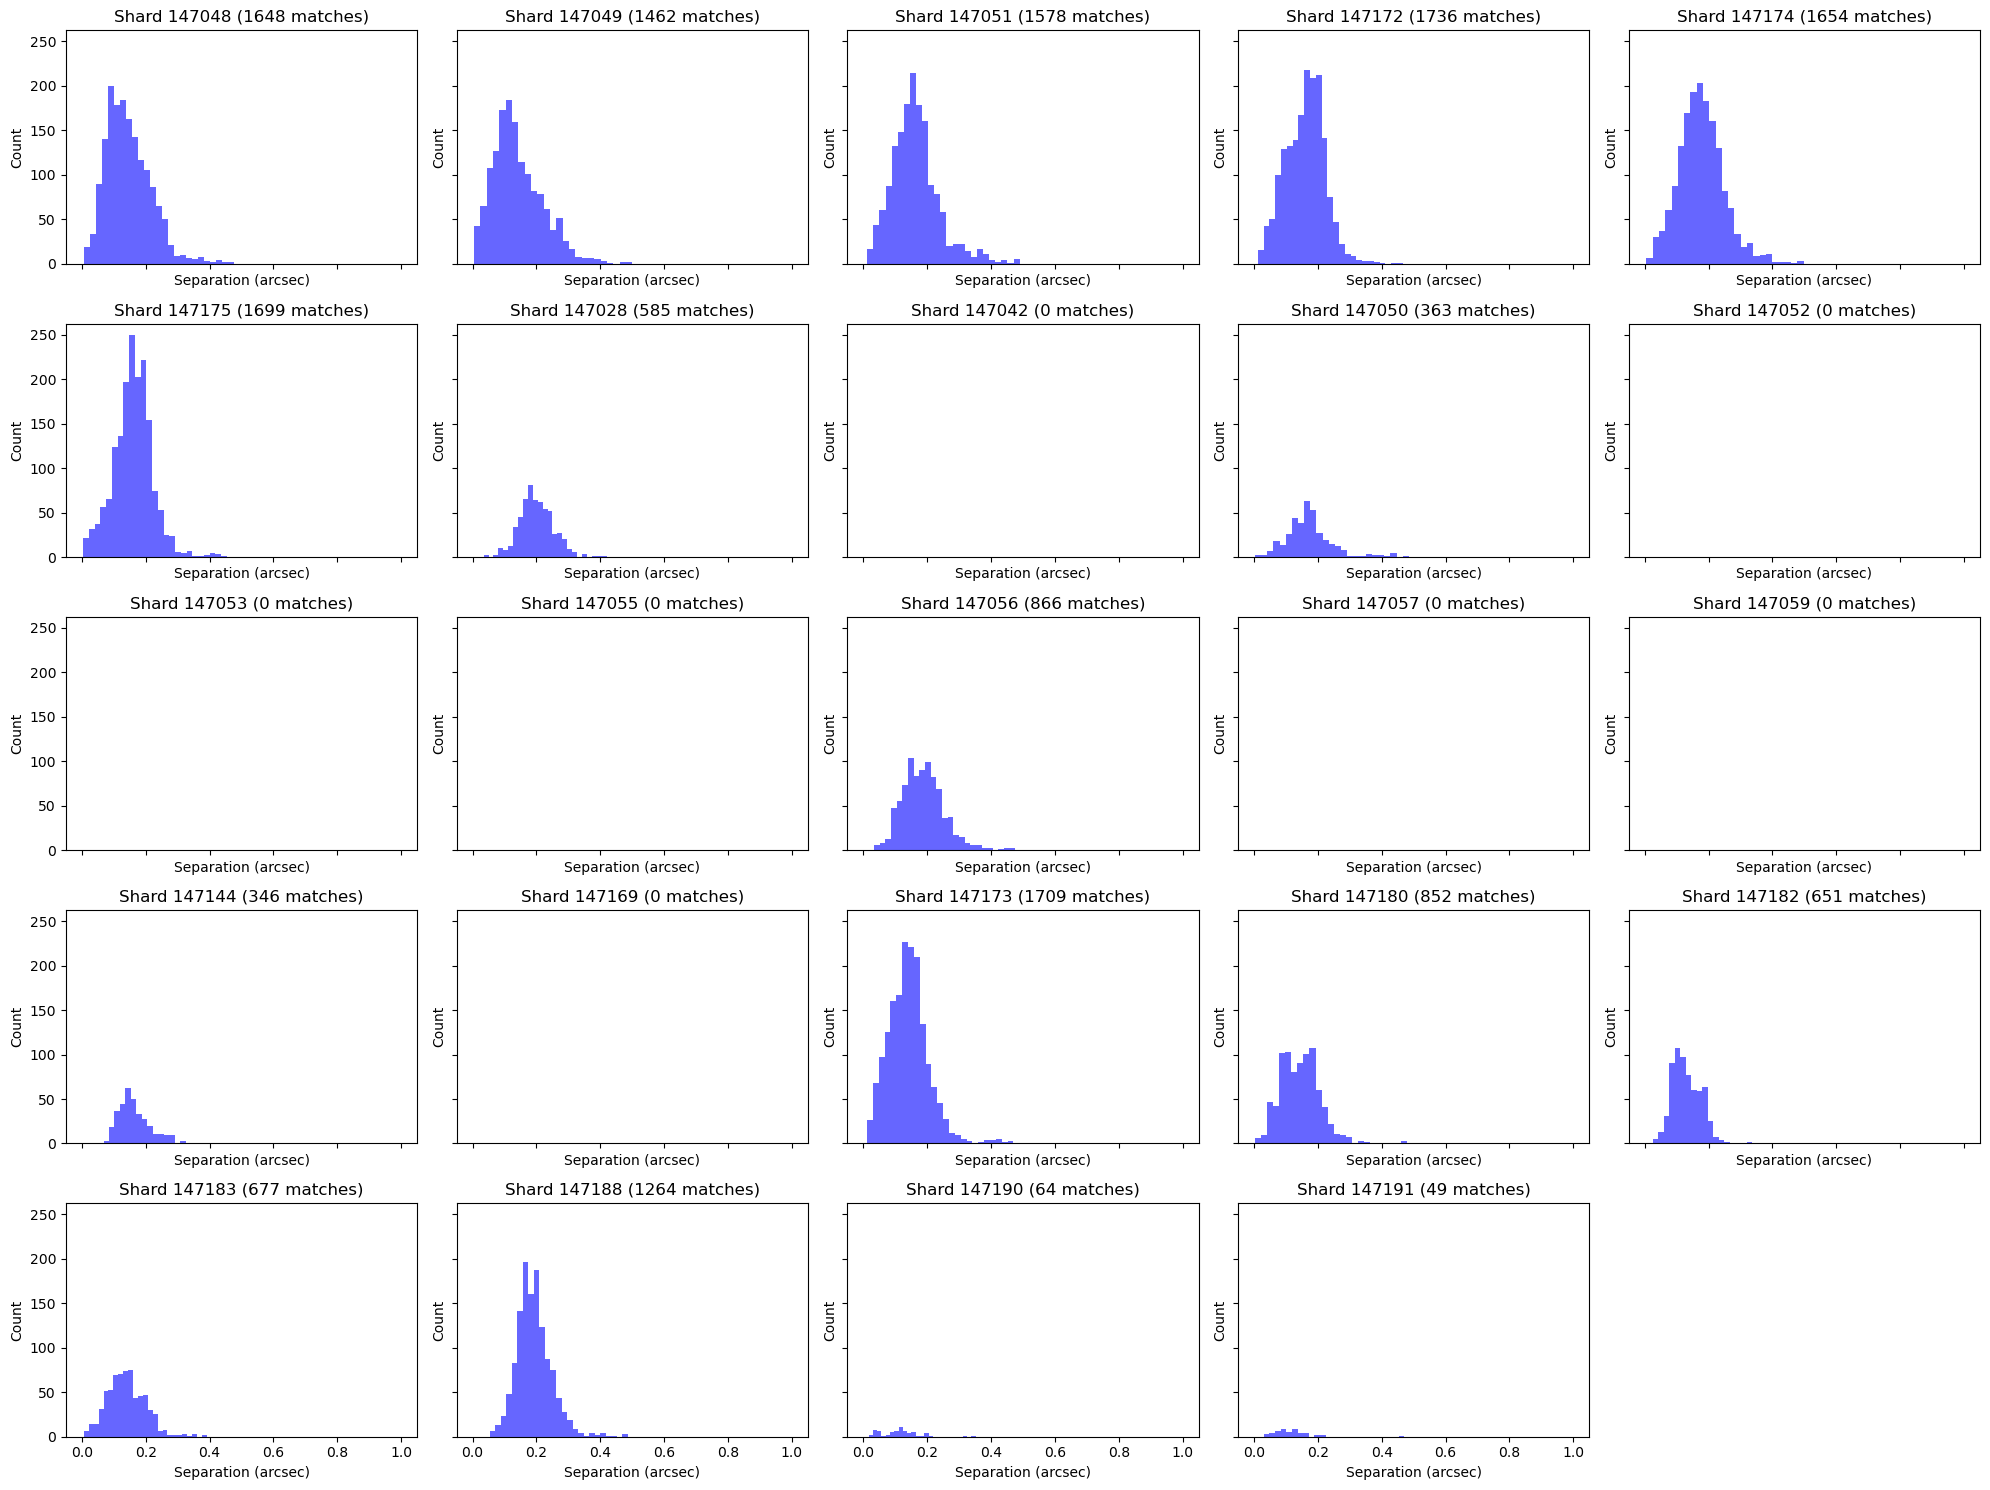

In [9]:
import matplotlib.pyplot as plt

# Suppose `all_separations` is {htm7_id: sep_arcsec_array}
n_shards = len(all_separations)
ncols = 5
nrows = int(np.ceil(n_shards / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 3*nrows), sharex=True, sharey=True)

for ax, (htm_id, sep_arcsec) in zip(axes.flat, all_separations.items()):
    ax.hist(sep_arcsec, bins=25, color="blue", alpha=0.6)
    ax.set_title(f"Shard {htm_id} ({len(sep_arcsec)} matches)")
    ax.set_xlabel("Separation (arcsec)")
    ax.set_ylabel("Count")

# Hide empty subplots if grid > n_shards
for ax in axes.flat[n_shards:]:
    ax.axis("off")

plt.tight_layout()
plt.show()